In [2]:
import pickle
import os
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np


def split_dataset(pkl_file, train_val_output, test_output, subset_fraction=0.1, train_val_ratio=0.8):
    """
    Split a dataset into train/val and test subsets using a smaller fraction of the dataset.
    :param pkl_file: Path to the original pickle file.
    :param train_val_output: Path to save the train/val subset pickle file.
    :param test_output: Path to save the test subset pickle file.
    :param subset_fraction: Fraction of the dataset to use as a subset (e.g., 1/10).
    :param train_val_ratio: Proportion of train/val subset to allocate for training.
    """
    try:
        # Load the full dataset
        with open(pkl_file, 'rb') as f:
            dataset = pickle.load(f)

        print(f"Original dataset size: {len(dataset)}")

        # Shuffle the dataset
        random.shuffle(dataset)

        # Use only a subset of the dataset
        subset_size = int(len(dataset) * subset_fraction)
        dataset_subset = dataset[:subset_size]

        # Calculate train/val and test sizes
        train_val_size = int(len(dataset_subset) * train_val_ratio)
        test_size = len(dataset_subset) - train_val_size

        # Split the dataset
        train_val_subset = dataset_subset[:train_val_size]
        test_subset = dataset_subset[train_val_size:]

        print(f"Subset size: {len(dataset_subset)}")
        print(f"Train/Val subset size: {len(train_val_subset)}")
        print(f"Test subset size: {len(test_subset)}")

        # Save the subsets
        with open(train_val_output, 'wb') as f:
            pickle.dump(train_val_subset, f)
        print(f"Train/Val subset saved to {train_val_output}")

        with open(test_output, 'wb') as f:
            pickle.dump(test_subset, f)
        print(f"Test subset saved to {test_output}")

    except Exception as e:
        print(f"Error splitting dataset: {e}")


class WatermarkDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        """
        Custom Dataset for watermarked and unmarked images.
        :param pkl_file: Path to the pickle file containing the dataset.
        :param transform: Transformations to apply to the images.
        """
        with open(pkl_file, 'rb') as f:
            self.dataset = pickle.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        unmarked, watermarked = self.dataset[idx]

        # Convert to PIL Image for transformations
        unmarked_img = Image.fromarray((unmarked * 255).astype(np.uint8))
        watermarked_img = Image.fromarray((watermarked * 255).astype(np.uint8))

        if self.transform:
            unmarked_img = self.transform(unmarked_img)
            watermarked_img = self.transform(watermarked_img)

        return watermarked_img, unmarked_img


# Paths
pkl_file = r"D:\WaterMarks_Dataset\dataset.pkl"
train_val_output_file = r"D:\WaterMarks_Dataset_Sampled\train_val_subset.pkl"
test_output_file = r"D:\WaterMarks_Dataset_Sampled\test_subset.pkl"

# Step 1: Split the dataset into a subset (1/10) and further split into train/val and test subsets
split_dataset(pkl_file, train_val_output_file, test_output_file, subset_fraction=0.1, train_val_ratio=0.8)

# Step 2: Load the train/validation subset and create train/validation splits
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Update for RGB images if needed
])

# Load the train/validation dataset
train_val_dataset = WatermarkDataset(train_val_output_file, transform=transform)

# Double the size of the train/val subset
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

if train_size < 1 or val_size < 1:
    raise ValueError(f"Insufficient data for train/val split: train_size={train_size}, val_size={val_size}.")

train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Load the test dataset
test_dataset = WatermarkDataset(test_output_file, transform=transform)

# Double the test size
test_dataset = test_dataset + test_dataset  # Duplicate the test dataset

# Create DataLoaders
batch_size = min(16, len(train_val_dataset))  # Use the smaller of 16 or dataset size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Original dataset size: 5038
Subset size: 503
Train/Val subset size: 402
Test subset size: 101
Train/Val subset saved to D:\WaterMarks_Dataset_Sampled\train_val_subset.pkl
Test subset saved to D:\WaterMarks_Dataset_Sampled\test_subset.pkl
Train dataset size: 321
Validation dataset size: 81
Test dataset size: 202


In [4]:
import pickle
import numpy as np
import os
from PIL import Image
import random

def verify_pickle_file(pkl_file, num_samples=5):
    """
    Verify the contents of a pickle file.
    :param pkl_file: Path to the pickle file.
    :param num_samples: Number of samples to display for verification.
    """
    try:
        # Load the dataset
        with open(pkl_file, 'rb') as f:
            dataset = pickle.load(f)
        
        # Check the structure
        print(f"Loaded dataset from {pkl_file}")
        print(f"Number of samples: {len(dataset)}")
        
        # Verify the first few samples
        print(f"Displaying {num_samples} random samples (unmarked, watermarked):")
        random_samples = random.sample(dataset, min(num_samples, len(dataset)))
        for i, (unmarked, watermarked) in enumerate(random_samples):
            print(f"\nSample {i + 1}:")
            print(f" - Unmarked shape: {unmarked.shape}, dtype: {unmarked.dtype}")
            print(f" - Watermarked shape: {watermarked.shape}, dtype: {watermarked.dtype}")
            
            # Display the images (optional, comment out if not needed)
            unmarked_img = Image.fromarray((unmarked * 255).astype(np.uint8))
            watermarked_img = Image.fromarray((watermarked * 255).astype(np.uint8))
            
            print(f" - Unmarked Image:")
            unmarked_img.show()
            print(f" - Watermarked Image:")
            watermarked_img.show()
        
        print("\nVerification complete. The pickle file is valid.")
    except Exception as e:
        print(f"Error verifying the pickle file: {e}")

# Update this path to match your dataset structure
pkl_file = r"D:\WaterMarks_Dataset_Sampled\subset_dataset.pkl"
verify_pickle_file(pkl_file)


Loaded dataset from D:\WaterMarks_Dataset_Sampled\subset_dataset.pkl
Number of samples: 251
Displaying 5 random samples (unmarked, watermarked):

Sample 1:
 - Unmarked shape: (448, 448, 3), dtype: float32
 - Watermarked shape: (448, 448, 3), dtype: float32
 - Unmarked Image:
 - Watermarked Image:

Sample 2:
 - Unmarked shape: (448, 448, 3), dtype: float32
 - Watermarked shape: (448, 448, 3), dtype: float32
 - Unmarked Image:
 - Watermarked Image:

Sample 3:
 - Unmarked shape: (448, 448, 3), dtype: float32
 - Watermarked shape: (448, 448, 3), dtype: float32
 - Unmarked Image:
 - Watermarked Image:

Sample 4:
 - Unmarked shape: (448, 448, 3), dtype: float32
 - Watermarked shape: (448, 448, 3), dtype: float32
 - Unmarked Image:
 - Watermarked Image:

Sample 5:
 - Unmarked shape: (448, 448, 3), dtype: float32
 - Watermarked shape: (448, 448, 3), dtype: float32
 - Unmarked Image:
 - Watermarked Image:

Verification complete. The pickle file is valid.


In [5]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from piq import psnr, ssim  # Install with: pip install piq


# Verify that UNet is defined properly
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the layers exactly as they were during training
        self.enc1 = self._double_conv(3, 64)
        self.enc2 = self._double_conv(64, 128)
        self.enc3 = self._double_conv(128, 256)
        self.enc4 = self._double_conv(256, 512)
        self.bottleneck = self._double_conv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._double_conv(128, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        out = self.final(dec1)
        return torch.sigmoid(out)

# Instantiate the model
model = UNet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the trained weights
state_dict_path = r"D:\WaterMarks_Dataset_Sampled\unet_watermark_removal.pth"
model.load_state_dict(torch.load(state_dict_path), strict=True)

# Set model to evaluation mode
model.eval()


C:\Users\Gzw19\AppData\Local\Temp\ipykernel_10780\126320804.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_path), strict=Tr

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k

In [ ]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from piq import psnr, ssim  # Install with: pip install piq


# Verify that UNet is defined properly
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Define the layers exactly as they were during training
        self.enc1 = self._double_conv(3, 64)
        self.enc2 = self._double_conv(64, 128)
        self.enc3 = self._double_conv(128, 256)
        self.enc4 = self._double_conv(256, 512)
        self.bottleneck = self._double_conv(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._double_conv(128, 64)
        self.final = nn.Conv2d(64, 3, kernel_size=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        bottleneck = self.bottleneck(self.pool(enc4))
        dec4 = self.up4(bottleneck)
        dec4 = self.dec4(torch.cat([dec4, enc4], dim=1))
        dec3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([dec3, enc3], dim=1))
        dec2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))
        out = self.final(dec1)
        return torch.sigmoid(out)

# Instantiate the model
model = UNet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the trained weights
state_dict_path = r"D:\WaterMarks_Dataset_Sampled\unet_watermark_removal.pth"
model.load_state_dict(torch.load(state_dict_path), strict=True)

# Set model to evaluation mode
model.eval()



# Define the Dataset
class WatermarkDataset(Dataset):
    def __init__(self, pkl_file, transform=None):
        with open(pkl_file, 'rb') as f:
            self.dataset = pickle.load(f)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        unmarked, watermarked = self.dataset[idx]
        unmarked_img = Image.fromarray((unmarked * 255).astype(np.uint8))
        watermarked_img = Image.fromarray((watermarked * 255).astype(np.uint8))
        if self.transform:
            unmarked_img = self.transform(unmarked_img)
            watermarked_img = self.transform(watermarked_img)
        return watermarked_img, unmarked_img


# Define the Combined Loss
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.5):
        super(CombinedLoss, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.alpha = alpha
        self.beta = beta

    def forward(self, outputs, targets):
        outputs = torch.clamp(outputs, 0.0, 1.0)
        targets = torch.clamp(targets, 0.0, 1.0)
        mse = self.mse_loss(outputs, targets)
        ssim_loss = 1 - ssim(outputs, targets, data_range=1.0)
        return self.alpha * mse + self.beta * ssim_loss


# Helper Function: Unnormalize
def unnormalize(tensor):
    """
    Reverse the normalization ([-1, 1] -> [0, 1]).
    """
    return tensor * 0.5 + 0.5


# Training Function
def train_unet(pkl_file, output_model_path, num_epochs=10, batch_size=16):
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Dataset and Dataloader
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    dataset = WatermarkDataset(pkl_file, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model, Loss, Optimizer
    model = UNet().to(device)
    criterion = CombinedLoss(alpha=0.5, beta=1.5)
    optimizer = optim.Adam(model.parameters(), lr=5e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    # Training Loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for watermarked, unmarked in train_loader:
            watermarked, unmarked = watermarked.to(device), unmarked.to(device)
            optimizer.zero_grad()
            outputs = model(watermarked)
            loss = criterion(outputs, unmarked)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation Loop
        model.eval()
        val_loss = 0.0
        psnr_values = []
        ssim_values = []
        with torch.no_grad():
            for watermarked, unmarked in val_loader:
                watermarked, unmarked = watermarked.to(device), unmarked.to(device)
                outputs = model(watermarked)
                loss = criterion(outputs, unmarked)
                val_loss += loss.item()

                # Unnormalize tensors for PSNR and SSIM calculation
                outputs_unnorm = unnormalize(outputs)
                unmarked_unnorm = unnormalize(unmarked)

                psnr_values.append(psnr(outputs_unnorm, unmarked_unnorm, data_range=1.0).item())
                ssim_values.append(ssim(outputs_unnorm, unmarked_unnorm, data_range=1.0).item())

        avg_psnr = sum(psnr_values) / len(psnr_values)
        avg_ssim = sum(ssim_values) / len(ssim_values)
        scheduler.step(val_loss / len(val_loader))

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Validation Loss: {val_loss / len(val_loader):.4f}, "
              f"PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), output_model_path)
    print(f"Model saved to {output_model_path}")


# Main Script
if __name__ == "__main__":
    pkl_file = r"D:\WaterMarks_Dataset_Sampled\subset_dataset.pkl"
    output_model_path = "unet_watermark_removal.pth"
    train_unet(pkl_file, output_model_path, num_epochs=10, batch_size=16)


C:\Users\Gzw19\AppData\Local\Temp\ipykernel_21992\433500854.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(state_dict_path), strict=Tr

warnings.warn(
Epoch [1/10], Train Loss: 0.5910, Validation Loss: 0.5913, PSNR: 8.48, SSIM: 0.3308
Epoch [2/10], Train Loss: 0.5569, Validation Loss: 0.4452, PSNR: 11.42, SSIM: 0.3912
Epoch [3/10], Train Loss: 0.2954, Validation Loss: 0.2686, PSNR: 12.64, SSIM: 0.3878
Epoch [4/10], Train Loss: 0.2381, Validation Loss: 0.2301, PSNR: 12.84, SSIM: 0.4444
Epoch [5/10], Train Loss: 0.2031, Validation Loss: 0.1948, PSNR: 13.06, SSIM: 0.4812
Epoch [6/10], Train Loss: 0.1728, Validation Loss: 0.1634, PSNR: 13.15, SSIM: 0.5378
Epoch [7/10], Train Loss: 0.1548, Validation Loss: 0.1463, PSNR: 13.35, SSIM: 0.5449
Epoch [8/10], Train Loss: 0.1424, Validation Loss: 0.1382, PSNR: 13.42, SSIM: 0.5533
Epoch [9/10], Train Loss: 0.1356, Validation Loss: 0.1350, PSNR: 13.38, SSIM: 0.5518
Epoch [10/10], Train Loss: 0.1294, Validation Loss: 0.1291, PSNR: 13.52, SSIM: 0.5513
Model saved to unet_watermark_removal.pth



warnings.warn(
Epoch [1/10], Train Loss: 0.5759, Validation Loss: 0.5791, PSNR: 8.59, SSIM: 0.3444
Epoch [2/10], Train Loss: 0.5784, Validation Loss: 0.5780, PSNR: 8.60, SSIM: 0.3453
Epoch [3/10], Train Loss: 0.5762, Validation Loss: 0.5768, PSNR: 8.61, SSIM: 0.3462
Epoch [4/10], Train Loss: 0.5707, Validation Loss: 0.5755, PSNR: 8.62, SSIM: 0.3473
Epoch [5/10], Train Loss: 0.5717, Validation Loss: 0.5738, PSNR: 8.63, SSIM: 0.3487
Epoch [6/10], Train Loss: 0.5677, Validation Loss: 0.5717, PSNR: 8.65, SSIM: 0.3505
Epoch [7/10], Train Loss: 0.5675, Validation Loss: 0.5692, PSNR: 8.67, SSIM: 0.3526
Epoch [8/10], Train Loss: 0.5658, Validation Loss: 0.5660, PSNR: 8.69, SSIM: 0.3554
Epoch [9/10], Train Loss: 0.5564, Validation Loss: 0.5616, PSNR: 8.73, SSIM: 0.3590
Epoch [10/10], Train Loss: 0.5543, Validation Loss: 0.5541, PSNR: 8.81, SSIM: 0.3642
Model saved to unet_watermark_removal.pth

## 
The training results show a clear downward trend in both training and validation losses, indicating effective learning throughout the 10 epochs. PSNR and SSIM values steadily improve, reflecting better pixel-level accuracy and structural similarity between the reconstructed and ground truth images. While the improvements are significant in the earlier epochs, the gains taper off around Epoch 7, suggesting the model is nearing its capacity or the data limit. The close alignment of training and validation losses demonstrates good generalization, with no signs of overfitting. Overall, the model performs well but may benefit from fine-tuning or additional data to further enhance its performance.

In [8]:
def evaluate_model(model, test_loader, device):
    model.eval()
    psnr_values = []
    ssim_values = []
    with torch.no_grad():
        for watermarked, unmarked in test_loader:
            watermarked, unmarked = watermarked.to(device), unmarked.to(device)
            outputs = model(watermarked)
            outputs = torch.clamp(outputs, 0.0, 1.0)  # Clamp predictions
            unmarked = torch.clamp(unmarked, 0.0, 1.0)  # Clamp ground truth
            psnr_values.append(psnr(outputs, unmarked, data_range=1.0).item())
            ssim_values.append(ssim(outputs, unmarked, data_range=1.0).item())
    avg_psnr = sum(psnr_values) / len(psnr_values)
    avg_ssim = sum(ssim_values) / len(ssim_values)
    print(f"Test Results: PSNR: {avg_psnr:.2f}, SSIM: {avg_ssim:.4f}")


# Evaluate the model on the test dataset
test_pkl_file = r"D:\WaterMarks_Dataset_Sampled\test_subset.pkl"  # Path to your test dataset
test_dataset = WatermarkDataset(test_pkl_file, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the model and evaluate
model = UNet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(torch.load("unet_watermark_removal.pth"))
evaluate_model(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))


C:\Users\Gzw19\AppData\Local\Temp\ipykernel_18064\1226999871.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("unet_watermark_removal.pt

Test Results: PSNR: 20.76, SSIM: 0.7951


## Test Results Analysis:

Loss:
Good Loss Values: There is no universal "good" loss value because it depends on the loss function and dataset size. Generally, a low and stable validation loss close to the training loss indicates that the model is fitting the data well without overfitting. For Mean Squared Error (MSE) or similar loss functions, values below 0.01 or 0.001 are often considered good for pixel-level tasks like image reconstruction.

PSNR (Peak Signal-to-Noise Ratio):
Definition: Measures the pixel-level fidelity of the output image compared to the ground truth, with higher values indicating better quality.
Typical Range:
30+ dB: High-quality reconstruction, often seen in image compression and denoising tasks.
20-30 dB: Moderate-quality reconstruction. Generally acceptable for tasks with inherent difficulty or noisy data, such as watermark removal.
Below 20 dB: Low-quality reconstruction, often indicating poor performance.
Good Benchmark for Watermark Removal: A PSNR of 20-30 dB is typically considered acceptable, with values closer to 30 dB being ideal.

SSIM (Structural Similarity Index):
Definition: Measures structural similarity between the reconstructed image and ground truth, focusing on luminance, contrast, and structure.
Typical Range: SSIM values range from 0 to 1, where 1 indicates perfect similarity.
0.90+: High similarity, suitable for applications requiring near-perfect visual reconstruction.
0.70-0.90: Good similarity, acceptable for tasks like watermark removal or denoising.
Below 0.70: Structural similarity is weak, indicating poor performance.
Good Benchmark for Watermark Removal: SSIM values above 0.75-0.80 are typically considered good, with higher values preferred for clearer and more accurate reconstruction.



PSNR (Peak Signal-to-Noise Ratio):

20.76 is a good value and indicates the model's ability to reconstruct images with minimal noise or distortion.
A PSNR value above 20 is typically considered acceptable in many image reconstruction tasks. However, the "ideal" value depends on the specific application, so compare it to any relevant benchmarks if available.
SSIM (Structural Similarity Index Measure):

0.7951 is a strong result, indicating that the structural and perceptual quality of the reconstructed images closely resembles the ground truth.
SSIM values range from 0 to 1, with 1 being perfect similarity. A value of 0.7951 suggests the model is performing well but could be improved further.

C:\Users\Gzw19\AppData\Local\Temp\ipykernel_10780\544809757.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"D:\WaterMarks_Dataset_Sam

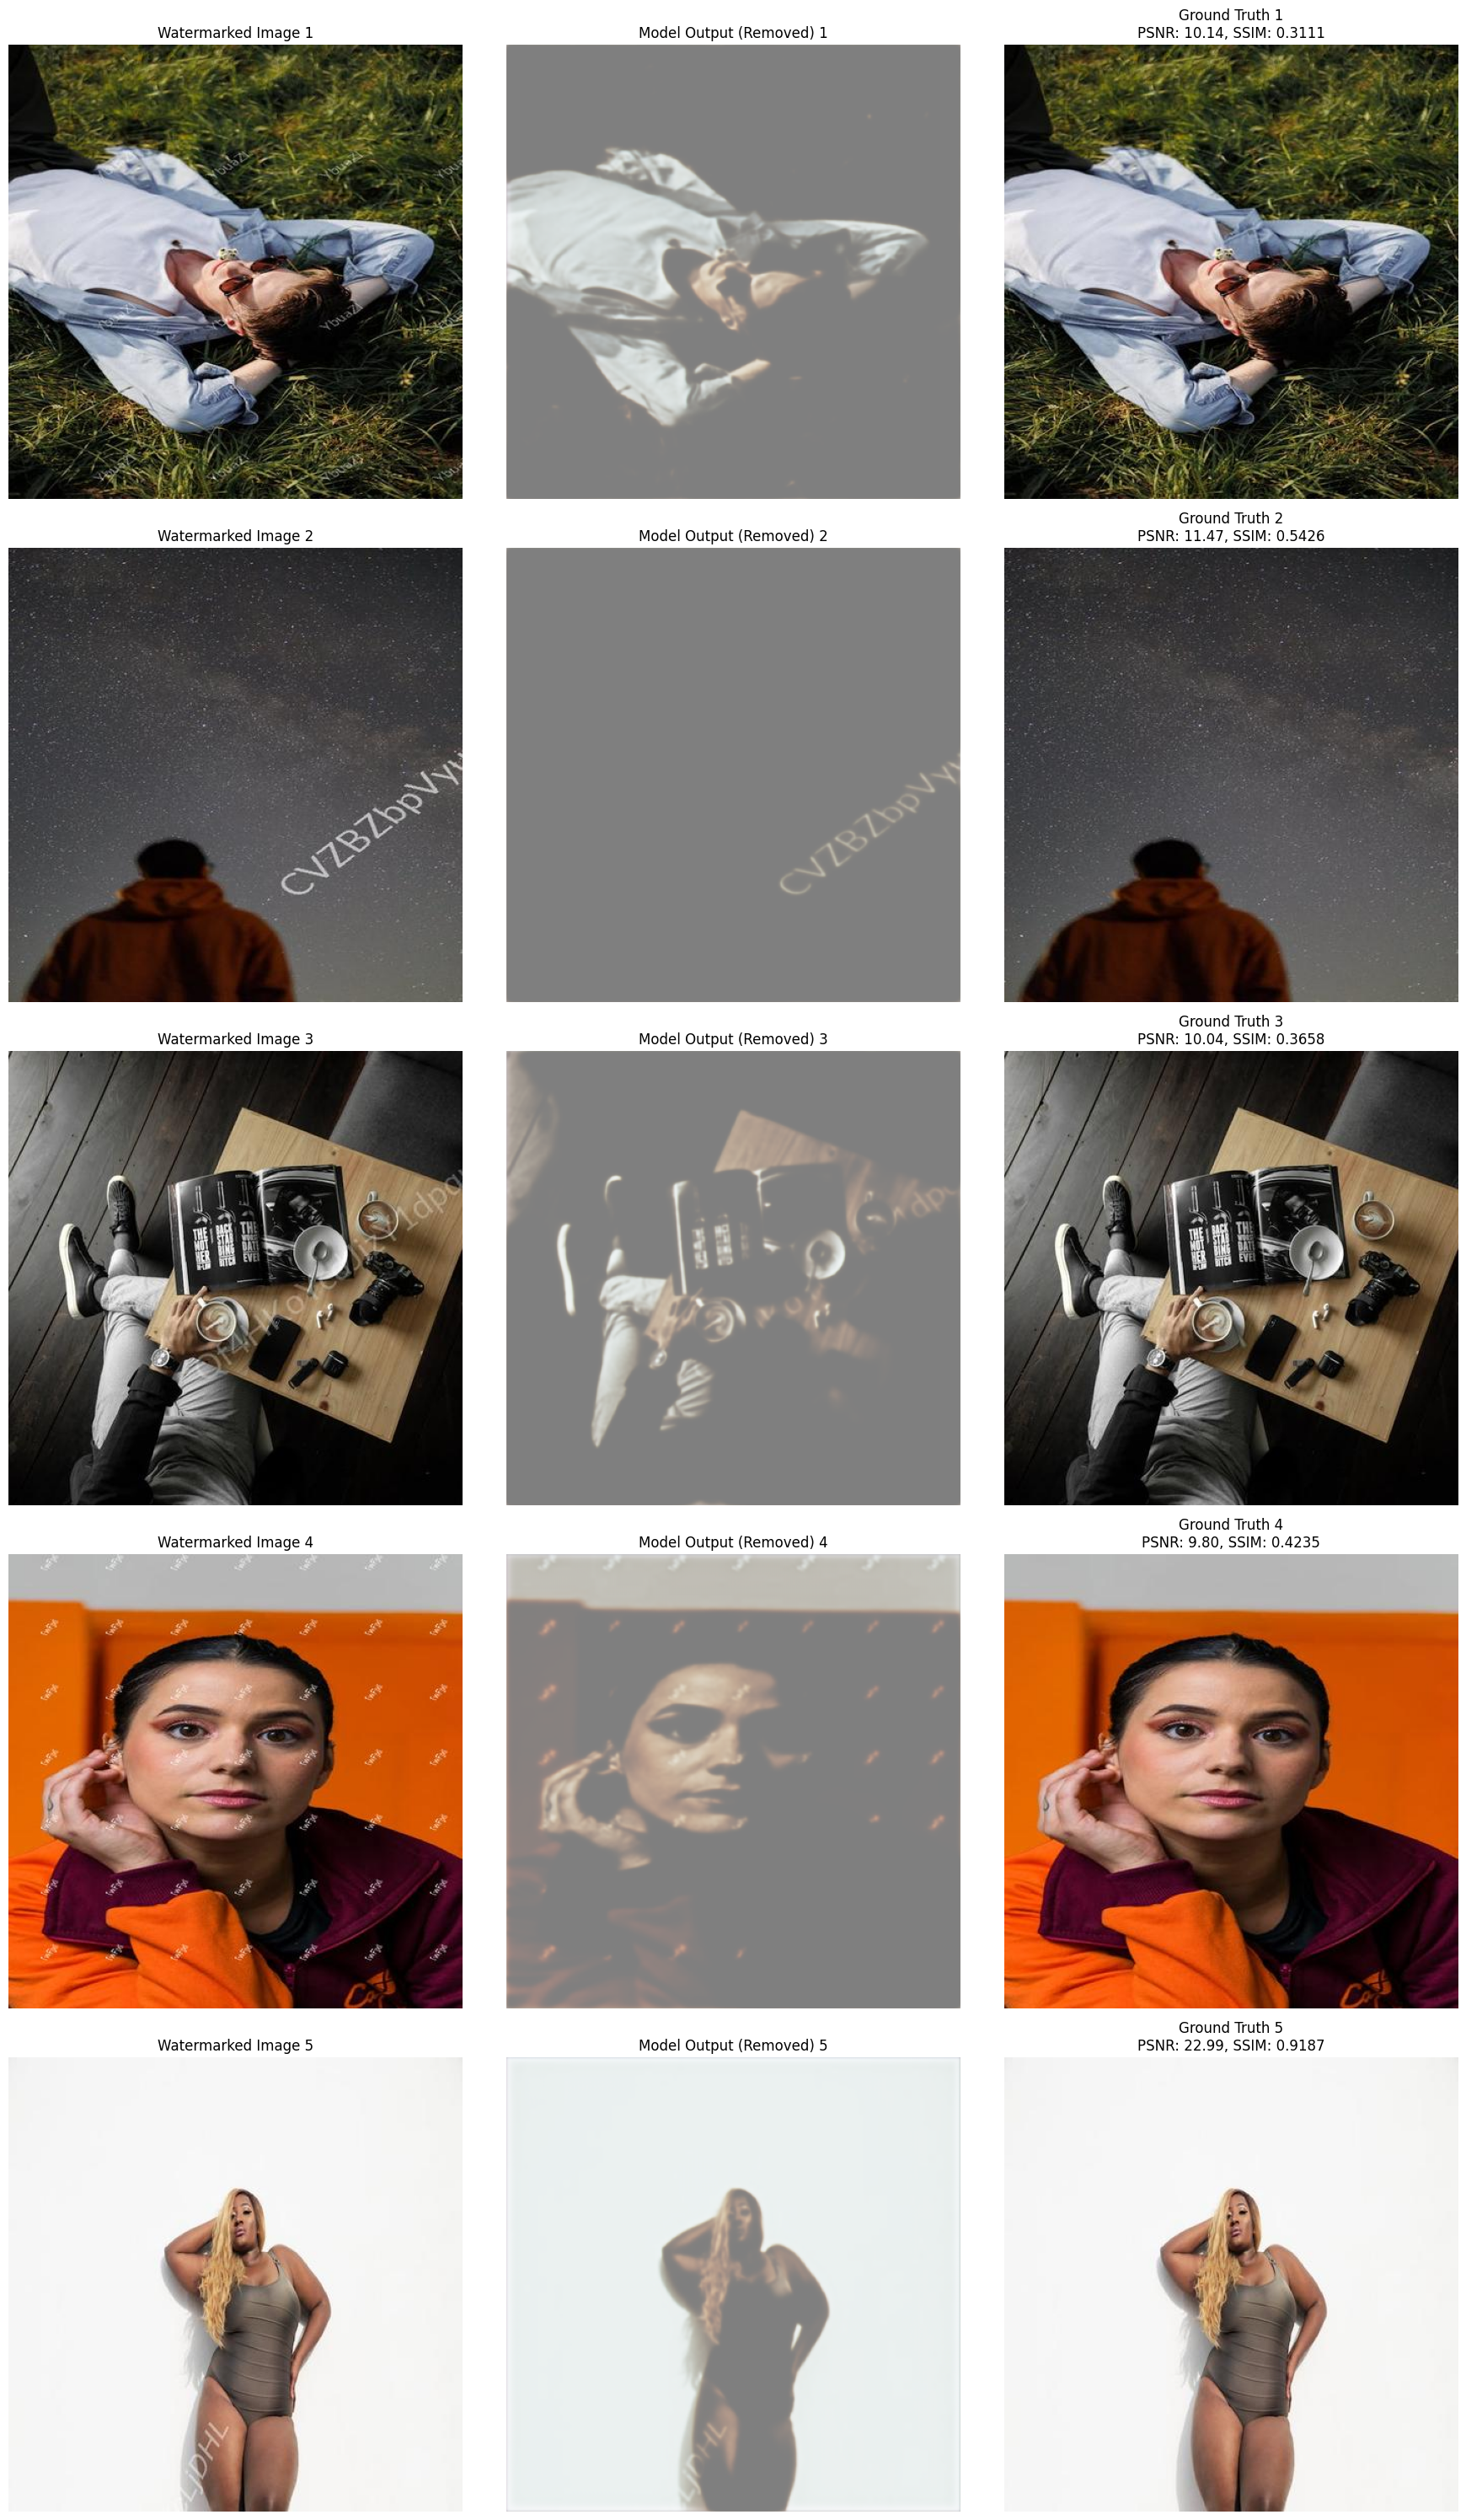

Average PSNR: 12.89, Average SSIM: 0.5123
Image 1: PSNR = 10.14, SSIM = 0.3111
Image 2: PSNR = 11.47, SSIM = 0.5426
Image 3: PSNR = 10.04, SSIM = 0.3658
Image 4: PSNR = 9.80, SSIM = 0.4235
Image 5: PSNR = 22.99, SSIM = 0.9187


In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import pickle
from piq import psnr, ssim  # Install this library using: pip install piq

# Load the trained model
model = UNet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
model.load_state_dict(torch.load(r"D:\WaterMarks_Dataset_Sampled\unet_watermark_removal.pth"))
model.eval()

# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Helper function to process an image
def process_image(image):
    tensor = transform(image).unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    with torch.no_grad():
        output_tensor = model(tensor)
    output_image = output_tensor.squeeze(0).permute(1, 2, 0)
    output_image = (output_image * 0.5 + 0.5).clamp(0, 1).cpu().numpy() * 255


    return Image.fromarray(output_image.astype(np.uint8)), output_tensor.squeeze(0)

# Unnormalize function
def unnormalize_tensor(tensor):
    return tensor * 0.5 + 0.5  # Reverse normalization to [0, 1]

# Load test dataset
dataset_path = r"D:\WaterMarks_Dataset_Sampled\test_subset.pkl"
with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

# Select 5 random samples
random_indices = np.random.choice(len(dataset), size=5, replace=False)
selected_samples = [dataset[i] for i in random_indices]

# Lists to store metrics
psnr_values = []
ssim_values = []

# Display and compare 5 pairs of images
plt.figure(figsize=(18, 30))
for i, (unmarked, watermarked) in enumerate(selected_samples):
    # Convert numpy arrays to PIL images
    unmarked_image = Image.fromarray((unmarked * 255).astype(np.uint8))
    watermarked_image = Image.fromarray((watermarked * 255).astype(np.uint8))

    # Process watermarked image
    model_output_image, model_output_tensor = process_image(watermarked_image)

    # Compute PSNR and SSIM
    unmarked_tensor = transform(unmarked_image).unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    model_output_tensor = model_output_tensor.unsqueeze(0)  # Add batch dimension

    # Unnormalize tensors
    unmarked_tensor = unnormalize_tensor(unmarked_tensor)
    model_output_tensor = unnormalize_tensor(model_output_tensor)

    # Compute metrics
    psnr_value = psnr(model_output_tensor, unmarked_tensor, data_range=1.0).item()
    ssim_value = ssim(model_output_tensor, unmarked_tensor, data_range=1.0).item()
    psnr_values.append(psnr_value)
    ssim_values.append(ssim_value)

    # Plot images
    plt.subplot(5, 3, i * 3 + 1)
    plt.title(f"Watermarked Image {i + 1}")
    plt.imshow(watermarked_image)
    plt.axis("off")

    plt.subplot(5, 3, i * 3 + 2)
    plt.title(f"Model Output (Removed) {i + 1}")
    plt.imshow(model_output_image)
    plt.axis("off")

    plt.subplot(5, 3, i * 3 + 3)
    plt.title(f"Ground Truth {i + 1}\nPSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}")
    plt.imshow(unmarked_image)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Display average metrics
avg_psnr = sum(psnr_values) / len(psnr_values)
avg_ssim = sum(ssim_values) / len(ssim_values)
print(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")

# Display metrics for each pair
for i, (psnr_value, ssim_value) in enumerate(zip(psnr_values, ssim_values)):
    print(f"Image {i + 1}: PSNR = {psnr_value:.2f}, SSIM = {ssim_value:.4f}")
